<a href="https://colab.research.google.com/github/ReinholdssonJ/dissertation/blob/main/V%C3%A4lkommen_till_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.cluster import KMeans

from scipy.optimize import linprog
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [24]:
df = pd.read_csv('/content/pfa_output.csv')



In [4]:
df_trim.head()


,PFA_Name,D08_LSOA_Low_Educational_Qualifications_2021_rate,D13_LSOA_Average_Unemployed_JSA_Claimant_Counts_1819_2021_rate,O41_LSOA_Rented_Households_2021_rate,R87_LSOA_no_Car_Households_2021_rate,D14_LSOA_Unemployed_Households_2021_rate,p63_p61b_msoa_population_estimates_age15_24_2021_rate,R83_LA_Upper_Urban_Road_Length_rate
0,Cleveland,0.312300,0.019250,0.382594,0.267936,0.056788,0.110710,0.697504
1,Durham,0.301526,0.015666,0.374362,0.242905,0.046091,0.119882,0.314980
2,Cheshire,0.257604,0.011135,0.312360,0.168732,0.029325,0.101536,0.451385
3,Lancashire,0.295908,0.014275,0.335977,0.222986,0.038390,0.118621,0.510995
4,Humberside,0.328671,0.014840,0.364452,0.235705,0.040132,0.106325,0.332289


In [5]:
crime_df = (pd.read_excel('/content/Crime data.xlsx')
  .drop(columns=['Area Code'])
  .melt(id_vars=['Area Name'], value_name='crimes')
  .drop(columns='variable')
  .groupby(by='Area Name')
  .sum()
)

pop_df = (pd.read_csv('/content/validation_metrics.csv',
                     usecols=['Force', 'Population 2023'])
)

crime_rate_df = (
    crime_df
      .merge(pop_df, left_on = 'Area Name', right_on = 'Force')
      .assign(inv_crime_rate = lambda x: x['Population 2023'] / x['crimes'],
              crime_rate = lambda x: x['crimes'] / x['Population 2023'])
      .sort_values('Force')
)[['Force', 'inv_crime_rate', 'crime_rate']]

crime_rate_df.head()

,Force,inv_crime_rate,crime_rate
0,Avon and Somerset,12.982765,0.077025
1,Bedfordshire,15.464997,0.064662
2,Cambridgeshire,13.884672,0.072022
3,Cheshire,12.820602,0.077999
4,Cleveland,10.282217,0.097255


# Functions

In [6]:
def dea_ccr_input(df, inputs, output):
    X = df[inputs].values
    Y = df[[output]].values

    n_dmus = X.shape[0]
    n_inputs = X.shape[1]

    efficiency = []

    for i in range(n_dmus):
        # Objective: minimize theta
        c = np.zeros(n_dmus + 1)
        c[-1] = 1  # theta

        A_ub = []
        b_ub = []

        # Input constraints: sum(lambda_j * x_jk) - theta * x_ik <= 0
        for k in range(n_inputs):
            row = np.zeros(n_dmus + 1)
            row[:n_dmus] = X[:, k]
            row[-1] = -X[i, k]
            A_ub.append(row)
            b_ub.append(0)

        # Output constraint: -sum(lambda_j * y_j) <= -y_i
        row = np.zeros(n_dmus + 1)
        row[:n_dmus] = -Y[:, 0]
        A_ub.append(row)
        b_ub.append(-Y[i, 0])

        # Bounds: lambda_j >= 0, theta in (0,1]
        bounds = [(0, None)] * n_dmus + [(0, 1)]

        res = linprog(
            c,
            A_ub=A_ub,
            b_ub=b_ub,
            bounds=bounds,
            method="highs"
        )

        efficiency.append(res.x[-1])

    return efficiency


In [7]:
def forward_stepwise_selection(X, y, criterion='aic'):
    remaining = list(X.columns)
    selected = []
    current_score = float('inf')

    while remaining:
        scores = []

        for candidate in remaining:
            X_candidate = sm.add_constant(X[selected + [candidate]])
            model = sm.OLS(y, X_candidate).fit()

            score = model.aic if criterion == 'aic' else model.bic
            scores.append((score, candidate))

        scores.sort()
        best_score, best_candidate = scores[0]

        if best_score < current_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_score
        else:
            break

    return selected


# Feature Selection

In [25]:
pre_selection = ['D08_LSOA_Low_Educational_Qualifications_2021_rate',
                 'D13_LSOA_Average_Unemployed_JSA_Claimant_Counts_1819_2021_rate',
                 'O41_LSOA_Rented_Households_2021_rate',
                 'R87_LSOA_no_Car_Households_2021_rate',
                 'D14_LSOA_Unemployed_Households_2021_rate',
                 'p63_p61b_msoa_population_estimates_age15_24_2021_rate',
                 'R83_LA_Upper_Urban_Road_Length_rate']

df_trim = df[['PFA_Name',
              pre_selection]]

TypeError: unhashable type: 'list'

In [62]:
cor_matrix  = pd.DataFrame(
    df
    .drop(columns=['PFA_Name', 'PFA_Code'])
    .corr(method='pearson')
)

Z_cor = linkage(cor_matrix, method='ward')

cor_matrix['cluster'] = fcluster(
    Z_cor,
    t=4,
    criterion='maxclust'
)

cor_matrix[['cluster']].head()

,cluster
D04_LSOA_Overcrowded_Households_Bedrooms_2021_rate,3
D06_LSOA_Overcrowded_Households_Rooms_2021_rate,4
D07_LSOA_3plusdeprivation_Households_2021_rate,1
D08_LSOA_Low_Educational_Qualifications_2021_rate,2
D13_LSOA_Average_Unemployed_JSA_Claimant_Counts_1819_2021_rate,1


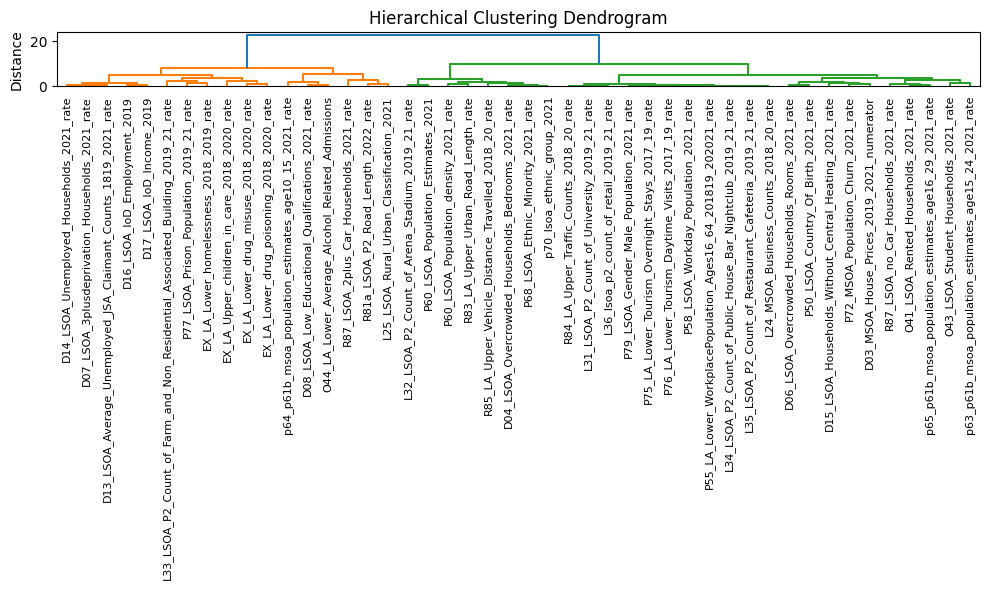

In [40]:
plt.figure(figsize=(10, 6))
dendrogram(
    Z_cor,
    labels=cor_matrix.index,  # optional
    leaf_rotation=90
)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [64]:
full_df = (df
   .merge(crime_rate_df, left_on='PFA_Name', right_on='Force')
   .drop(columns='Force')
)

crime_cor_df = (
    full_df
      .select_dtypes(include='number')
      .corr()['crime_rate']
      .sort_values(ascending=False)
)

indicators_df = (
    cor_matrix[['cluster']]
      .merge(crime_cor_df, left_index=True, right_index=True)
      .sort_values(['cluster', 'crime_rate'], ascending=False)
      .reset_index()
      .groupby('cluster')
      .head(1)
)

cluster_selection = indicators_df['index'].tolist()
cluster_selection

['R87_LSOA_no_Car_Households_2021_rate',
 'R83_LA_Upper_Urban_Road_Length_rate',
 'D08_LSOA_Low_Educational_Qualifications_2021_rate',
 'D14_LSOA_Unemployed_Households_2021_rate']

# PCA

In [72]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])


pca_array = pipeline.fit_transform(
    df[cluster_selection]
)

pca_df = (
    pd.DataFrame(pca_array,
                 columns=['PC1', 'PC2'])
    .merge(crime_rate_df, left_index=True, right_index=True)
)[['Force', 'PC1', 'PC2', 'crime_rate']]

pca_df.head()

,Force,PC1,PC2,crime_rate
0,Avon and Somerset,1.254022,2.266254,0.077025
1,Bedfordshire,-0.065344,1.027065,0.064662
2,Cambridgeshire,-0.156616,-0.626115,0.072022
3,Cheshire,0.237319,0.609659,0.077999
4,Cleveland,-0.380529,1.076489,0.097255


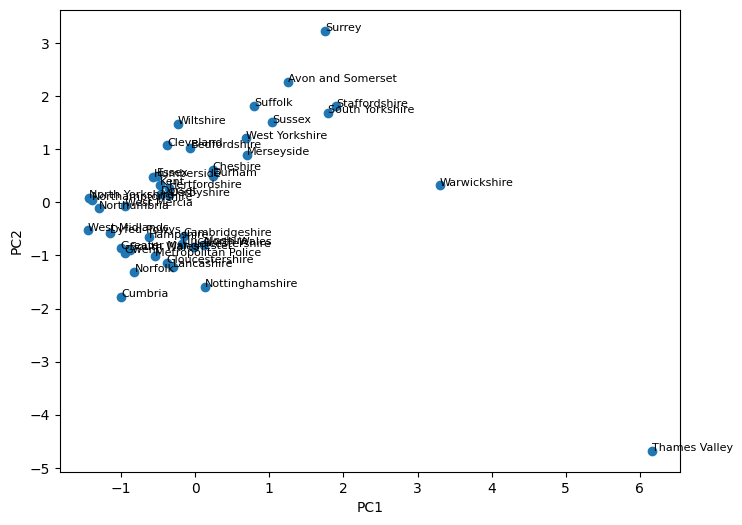

In [73]:
# pca_df.plot.scatter(x='PC1', y='inv_crime_rate')
# pca_df.plot.scatter(x='PC2', y='inv_crime_rate')
# pca_df.plot.scatter(x='PC1', y='PC2', data_label='Force')

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pca_df['PC1'], pca_df['PC2'])

for _, row in pca_df.iterrows():
    ax.text(row['PC1'], row['PC2'], row['Force'], fontsize=8)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.show()


# DEA

In [10]:
df_dea = (
    df_trim
     .merge(crime_rate_df, left_on='PFA_Name', right_on='Force')
     .drop(columns='Force')
)

df_dea_scaled = pd.DataFrame(
    MinMaxScaler().fit_transform(df_dea.drop(columns='PFA_Name')),
    columns=df_dea.columns[1:],
    index=df_dea['PFA_Name']
)

df_dea_scaled.describe()

,D08_LSOA_Low_Educational_Qualifications_2021_rate,D13_LSOA_Average_Unemployed_JSA_Claimant_Counts_1819_2021_rate,O41_LSOA_Rented_Households_2021_rate,R87_LSOA_no_Car_Households_2021_rate,D14_LSOA_Unemployed_Households_2021_rate,p63_p61b_msoa_population_estimates_age15_24_2021_rate,R83_LA_Upper_Urban_Road_Length_rate,inv_crime_rate,crime_rate
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.547340,0.391633,0.239126,0.252365,0.361990,0.415125,0.404959,0.431362,0.402000
std,0.233363,0.223626,0.174177,0.195715,0.246568,0.265962,0.247207,0.252518,0.249387
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.364439,0.235826,0.128722,0.127100,0.174115,0.223614,0.237685,0.277032,0.225313
50%,0.607567,0.320045,0.203041,0.171362,0.293427,0.326554,0.387213,0.411048,0.367857
75%,0.740663,0.538407,0.275939,0.363927,0.594355,0.572964,0.507031,0.582712,0.514540
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
import statsmodels.api as sm

y = df_dea_scaled['crime_rate']
X = df_dea_scaled[['D08_LSOA_Low_Educational_Qualifications_2021_rate',
                   'D13_LSOA_Average_Unemployed_JSA_Claimant_Counts_1819_2021_rate',
                   'O41_LSOA_Rented_Households_2021_rate',
                   'R87_LSOA_no_Car_Households_2021_rate',
                   'D14_LSOA_Unemployed_Households_2021_rate',
                   'p63_p61b_msoa_population_estimates_age15_24_2021_rate',
                   'R83_LA_Upper_Urban_Road_Length_rate']]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             crime_rate   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     7.639
Date:                Mon, 29 Dec 2025   Prob (F-statistic):           1.76e-05
Time:                        12:29:38   Log-Likelihood:                 19.017
No. Observations:                  41   AIC:                            -22.03
Df Residuals:                      33   BIC:                            -8.325
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                              0.0552      0.097      0.571      0.572      -0.141       0.252
D08_LSOA_Low_Educational_Qualifications_2021_rate                 -0.0026      0.182     -0.014      0.989      -0.373       0.368
D13_LSOA_Average_Unemployed_JSA_Claimant_Counts_1819_2021_rate     0.3529      0.416      0.847      0.403      -0.494       1.200
O41_LSOA_Rented_Households_2021_rate                              -0.0039      0.357     -0.011      0.991      -0.731       0.723
R87_LSOA_no_Car_Households_2021_rate                               0.2078      0.389      0.534      0.597      -0.585       1.000
D14_LSOA_Unemployed_Households_2021_rate                           0.1876      0.376      0.499      0.621      -0.577       0.952
p63_p61b_msoa_population_estimates_age15_24_2021_rate              0.0773      0.140      0.554      0.583      -0.207       0.361
R83_LA_Upper_Urban_Road_Length_rate                                0.1445      0.196      0.739      0.465      -0.254       0.543
==============================================================================
Omnibus:                        2.314   Durbin-Watson:                   2.616
Prob(Omnibus):                  0.315   Jarque-Bera (JB):                1.296
Skew:                          -0.349   Prob(JB):                        0.523
Kurtosis:                       3.520   Cond. No.                         31.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5))
])

pipe.fit(X, y)
selected = X.columns[pipe.named_steps['lasso'].coef_ != 0]
selected

Index(['D13_LSOA_Average_Unemployed_JSA_Claimant_Counts_1819_2021_rate',
       'R87_LSOA_no_Car_Households_2021_rate',
       'D14_LSOA_Unemployed_Households_2021_rate',
       'R83_LA_Upper_Urban_Road_Length_rate'],
      dtype='object')

In [13]:
df_dea_scaled['efficiency'] = dea_ccr_input(
    df_dea_scaled,
    inputs=['D13_LSOA_Average_Unemployed_JSA_Claimant_Counts_1819_2021_rate',
            'R87_LSOA_no_Car_Households_2021_rate',
            'D14_LSOA_Unemployed_Households_2021_rate',
            'R83_LA_Upper_Urban_Road_Length_rate'],
    output='crime_rate'
)

pca_df['efficiency']

KeyError: 'efficiency'

# Clustering

### K-Means

In [14]:
kmeans = KMeans(n_clusters=3,
                n_init = 20,
                random_state=42
)

clusters = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

pca_df['cluster'] = clusters
#pca_df

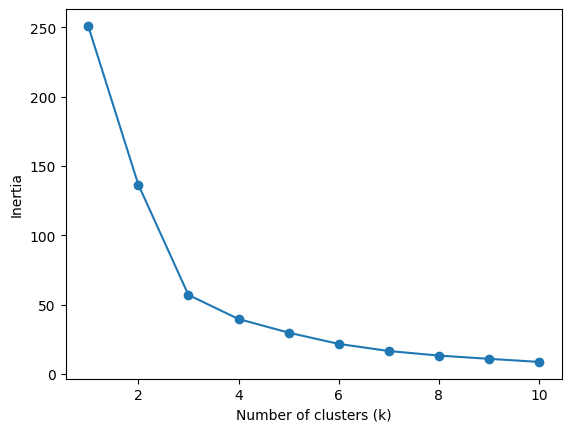

In [15]:
inertia = []

for k in range(1, 11):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(pca_df[['PC1', 'PC2']])
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


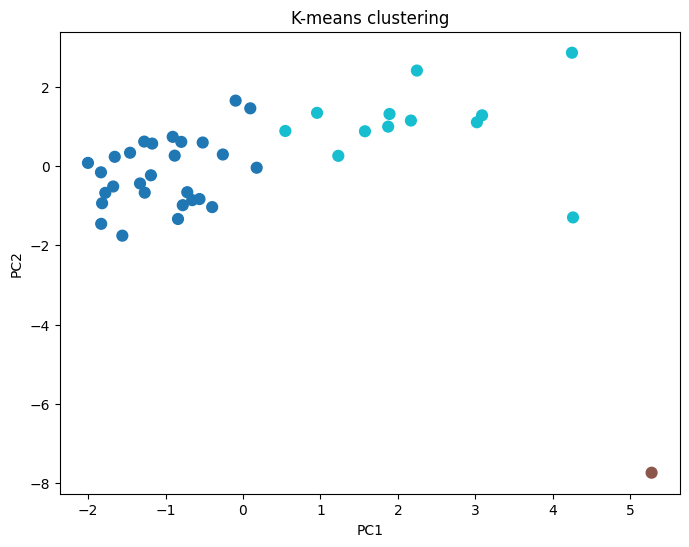

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    c=pca_df['cluster'],
    cmap='tab10',
    s=60
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K-means clustering')

plt.show()

### H-Cluster

In [20]:
Z = linkage(pca_df[['PC1', 'PC2']],
            method='ward')

pca_df['cluster'] = fcluster(
    Z,
    t=4,
    criterion='maxclust'
)

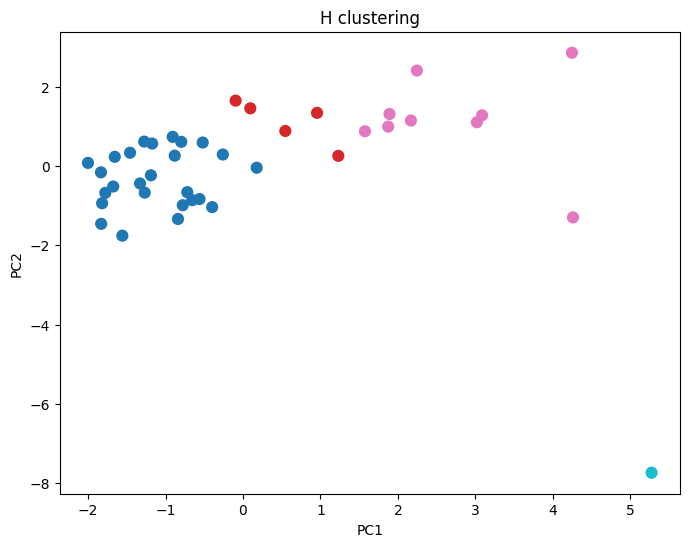

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    pca_df['PC1'],
    pca_df['PC2'],
    c=pca_df['cluster'],
    cmap='tab10',
    s=60
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('H clustering')

plt.show()

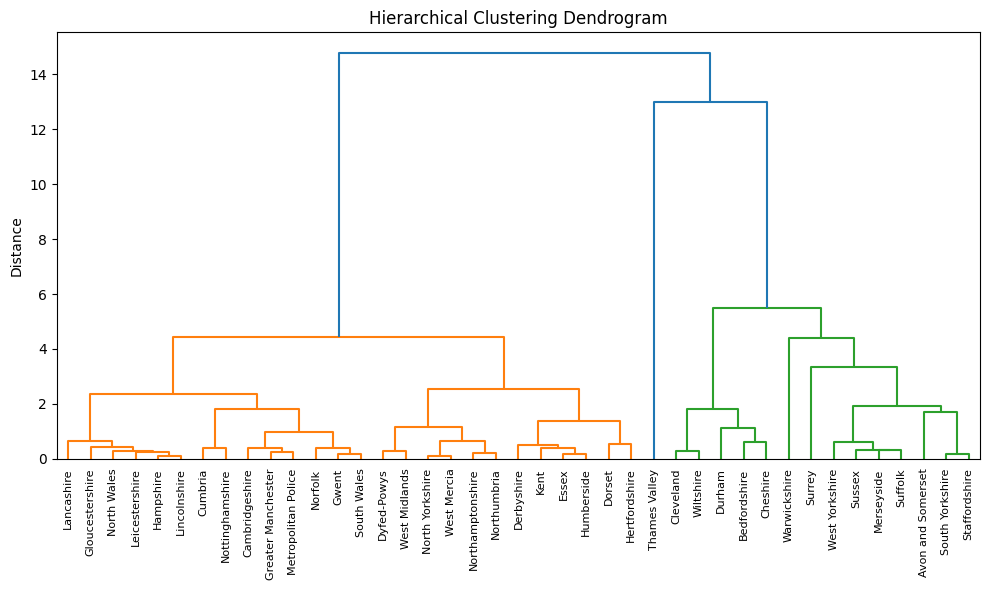

In [22]:
plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    labels=pca_df['Force'].values,  # optional
    leaf_rotation=90
)
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()